# Langmuir probe data

Langmuir probes are the bread and butter of plasma diagnsotics. In AUG they are spread through the inner and outer divertors. Some of them tend to go MIA in some days, so always check out for individual signals. The naming convention is always something like "ua1". The first "u" is for "unten" (lower), so the first letter can be either "u" or "o" (oben). The second letter can be "a" for "ausen" (outer), "i" for "innen" (inner) or "m" for "mitte" (middle, in the lower divertor roof baffle).

Reading temperature and density for the probes is straightforward, as the information is stored in the `LSD` shotfile (yep, LSD, *LangmuirSondenDaten, jungs*). To get the particular info, you can compose the name of the signal by adding the prefix `te-` for temperature and `ne-` for density. 

Reading jsat information, however, is a bloody nightmare. Ain't nobody got time for that.

It is much easier to read data from the `DIVERTOR` programme written by Steffen Potzel and outputting ASCII files than you reading the data itself. There are some functions to read data outputted by DIVERTOR.

EDIT: Agree to disagree, it's better to fetch the data yourself. I think you cannot get data for the upper divertor from the `DIVERTOR` program, plus the interface is old and ugly like my grandma.

In [1]:
%matplotlib notebook
%pdb

from ipfnpytools.getsig import getsig
import matplotlib.pyplot as plt
from ipfnpytools.getVessel import getVessel
from ipfnpytools.plotVessel import plotVessel
from divertor import get_probe_coordinates, plot_probes, get_jsat, probe_jsat_channel
import numpy as np
from scipy.signal import medfilt


Automatic pdb calling has been turned ON


In [2]:
# General parameters
shot = 32430

# median_pts = 501

mean_pts = 501

First things first. Let's take a look at the probes laid out on the tokamak using ipfnpytools built-in functions

In [3]:
# Get the vessel information
vessel = getVessel(shot)

In [4]:
# Get the divertor probes' names and coordinates
filepath = 'Files/29864_lower_divertor_langmuir_probes.coords'

meta_data, names, radius, height = get_probe_coordinates(filepath)
print(meta_data)

# Get the divertor probes' names and coordinates
filepath = 'Files/29864_upper_divertor_langmuir_probes.coords'

meta_data, a, b, c = get_probe_coordinates(filepath)
names.extend(a)
radius.extend(b)
height.extend(c)

print(meta_data)
print(names)

{'divertor': 'lower', 'shot': 29864, 'time': 1.6}
{'divertor': 'upper', 'shot': 29864, 'time': 1.6}
['8uae', '8uaf', '8uag', '8uah', 'uig', 'uif', 'uie', 'uid', 'uic', 'uib', 'uia', 'ui9', 'ui8', 'ui7', 'ui6', 'ui5', 'ui4', 'ui3', 'ui2', 'ui1', 'um1', 'um2', 'um3', 'um4', 'um5', 'um6', 'um7', 'um8', 'ua1', 'ua2', 'ua3', 'ua4', 'ua5', 'ua6', 'ua7', 'ua8', 'ua9', 'uaa', 'uab', 'uac', 'uad', 'oig', 'oif', 'oie', 'oid', 'oic', 'oib', 'oia', 'oi9', 'oi8', 'oi7', 'oi6', 'oi5', 'oi4', 'oi3', 'oi2', 'oi1', 'oa1', 'oa2', 'oa3', 'oa4', 'oa5', 'oa6', 'oa7', 'oa8', 'oa9']


In [5]:
from ipfnpytools.getVessel import getVessel
from ipfnpytools.plotVessel import plotVessel
import matplotlib.pyplot as plt
import numpy as np
import map_equ
from ipfnpytools.closest import closest

class Equilibrium:
    
    def __init__(self, equilibrium, countour, axes):
        self._eq = equilibrium 
        self._cs = countour
        self._ax = axes
        self._contourlevels = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.02, 1.04, 1.06])
        
    def __call__(self, time):
        index = closest(self._eq.t_eq, time)
        for col in self._cs.collections:
            col.remove()
            
        self._cs = self._ax.contour(
            self._eq.Rmesh, self._eq.Zmesh, 
            np.sqrt((self._eq.pfm[:,:,:] - self._eq.psi0)/(self._eq.psix-self._eq.psi0))[:,:,index].T,
            levels=self._contourlevels, linewidths=1.2, cmap='viridis_r'
        ) 

def plot_equilibrium(shot, time, equilibrium='EQH', axes=None):

    eq = map_equ.equ_map()
    eq.Open(shot, equilibrium)
    #Populate the fields
    eq.read_pfm()
    eq.read_scalars()
    #Get the index closest to the requested time
    index = closest(eq.t_eq, time)

    if axes is None:
        ax = plt.gca()
    else:
        ax = axes
        
    fig = ax.get_figure()
    
    contourlevels = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.02, 1.04, 1.06])

    cs = ax.contour(eq.Rmesh, eq.Zmesh, np.sqrt((eq.pfm[:,:,:] - eq.psi0)/(eq.psix-eq.psi0))[:,:,index].T,
                     levels=contourlevels, linewidths=1.2, cmap='viridis_r') 
    
    return Equilibrium(eq, cs, ax)

#     ax.set_aspect('equal')
#     ax.set_ylabel('Z [m]', labelpad=-5)
#     ax.set_xlabel('R [m]')
#     ax.set_title('%s #%d t=%0.2fs'%(magdiag, shotnr, time), loc='left')
#     ax.set_xlim(1.0, 2.32)
#     ax.set_ylim(-1.3, 1.3)
#     plt.tight_layout()
#     plt.show()

<IPython.core.display.Javascript object>


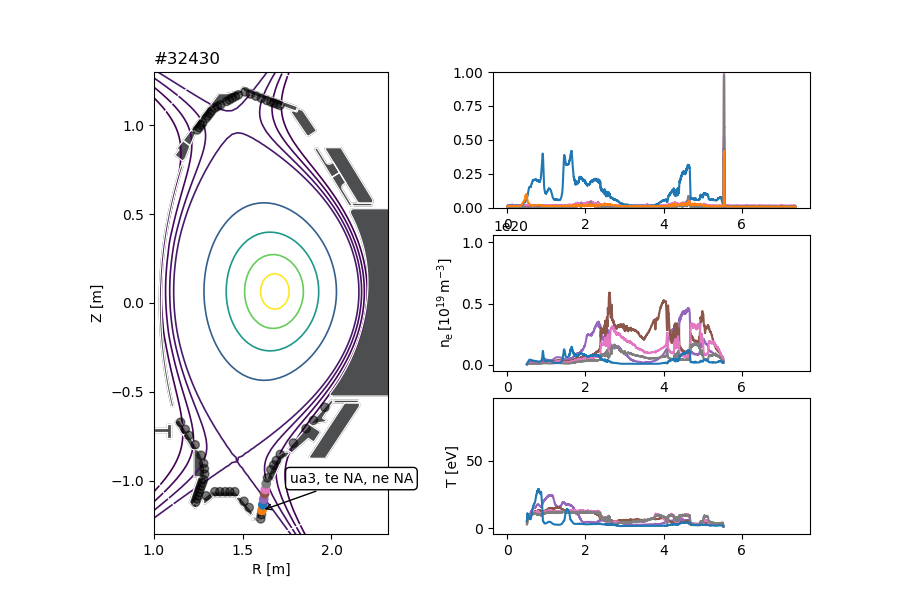

In [6]:
# Plotting the vessel
names = np.array(names)
radius = np.array(radius)
height = np.array(height)

fig = plt.figure(figsize=(9,6))
ax_vessel = fig.add_subplot(121)
ax_jsat = fig.add_subplot(322)
ax_ne = fig.add_subplot(324, sharex=ax_jsat)
ax_te = fig.add_subplot(326, sharex=ax_jsat)

# fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9,6))

plotVessel(vessel, ax_vessel, color_border='w', color_structure='#4D4E4F', lw_border=0.9)

plot_probes(radius, height, names, shot, axes_vessel=ax_vessel, axes_te=ax_te, axes_ne=ax_ne, axes_jsat=ax_jsat, mean_pts=mean_pts)

equilibrium = plot_equilibrium(shot, 3, axes=ax_vessel)

# for chan in evl_chans:
#     ax.plot(evl_los['signals'][chan]['0']['R'], evl_los['signals'][chan]['0']['z'], color='C2',lw=0.5)
    
ax_vessel.set_aspect('equal')
ax_vessel.set_ylabel('Z [m]')
ax_vessel.set_xlabel('R [m]')
ax_vessel.set_title('#'+str(shot), loc='left')
ax_vessel.set_xlim(1.0, 2.32)
ax_vessel.set_ylim(-1.3, 1.3)

ax_ne.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
ax_te.set_ylabel('T [eV]')

plt.show()

In [8]:
equilibrium(3.25)

In [11]:
ax_ne.get_children()[0].set_visible(not ax_ne.get_children()[0].get_visible())

In [136]:
shot = 29864
telfs = getsig(shot, 'LSD', 'te-ua4')
nelfs = getsig(shot, 'LSD', 'ne-ua4')

In [137]:
nelfs.time = nelfs.time[~np.isnan(nelfs.data)]
nelfs.data = nelfs.data[~np.isnan(nelfs.data)]

telfs.time = telfs.time[~np.isnan(telfs.data)]
telfs.data = telfs.data[~np.isnan(telfs.data)]

In [139]:
# fig, ax = plt.subplots(nrows=2, sharex=True, dpi=100)

ax_ne.plot(nelfs.time, nelfs.data*1e-19, lw=0.4)
ax_te.plot(telfs.time, telfs.data, lw=0.4)

ax_ne.plot(nelfs.time, post_process(nelfs.data*1e-19))
ax_te.plot(telfs.time, post_process(telfs.data))

# ax[0].set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
# ax[1].set_ylabel('T [eV]')

# ax[0].set_ylim(bottom=0)
# ax[1].set_ylim(bottom=0)

# ax[1].set_xlabel('time [s]')
# ax[1].set_xlim(1,4)
# plt.tight_layout()
# plt.show()

## Reading DIVERTOR output

In [4]:
from ipfnpytools.readStark import readDivData
from ipfnpytools.getsig import getsig
from scipy.interpolate import interp2d
import matplotlib as mpl #Special axes arrangement for colorbars
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import numpy as np
import matplotlib.pyplot as plt

In [5]:
jsat_out = readDivData('./Files/3D_29864_jsat_out.dat')
h1 = getsig(29864, 'DCN', 'H-1')
h5 = getsig(29864, 'DCN', 'H-5')
dtot = getsig(29864, 'UVS', 'D_tot')

/afs/ipp/aug/ads-diags/common/python/lib/dd.py:118: RuntimeWarning: Warning by DDcsgnl (8.1): no calibration of data
  warnings.warn(err_txt, RuntimeWarning)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/2/2019.03/lib/python2.7/site-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


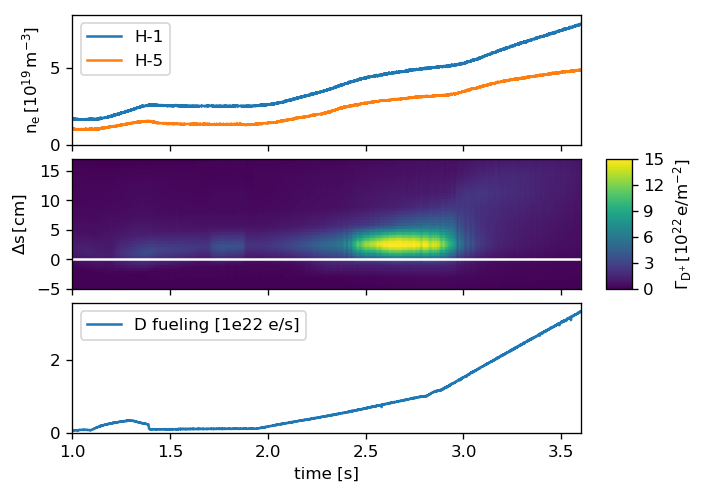

In [6]:
fig = plt.figure(dpi=120)

#Initial and Final time points
tBegin = 1.0
tEnd = 3.6

#2x2 array, left side for plotting, right side for placing colorbar, hence the ratios
gs = mpl.gridspec.GridSpec(3, 2, height_ratios=[1, 1, 1], width_ratios=[5, 1])

#Top plot
ax0 = fig.add_subplot(gs[0, 0])

ax0.plot(h1.time, h1.data*1e-19, label='H-1')
ax0.plot(h5.time, h5.data*1e-19, label='H-5')
ax0.set_ylabel(r'$\mathrm{n_{e}\,[10^{19}\,m^{-3}]}$')
ax0.set_ylim(bottom=0)
ax0.legend()

#Middle plot
ax1 = fig.add_subplot(gs[1, 0], sharex=ax0)

vmax = 15
clrb = ax1.pcolormesh(jsat_out.time, jsat_out.deltas, jsat_out.data, vmax=vmax, shading='gouraud', cmap='viridis')

axins = inset_axes(ax1,
                   width="5%", # width = 10% of parent_bbox width
                   height="100%", # height : 50%
                   loc=6,
                   bbox_to_anchor=(1.05, 0., 1, 1),
                   bbox_transform=ax1.transAxes,
                   borderpad=0)

cbar = plt.colorbar(clrb, cax=axins, ticks=(np.arange(0.0, vmax+1.0, 3.0)))
cbar.set_label(r'$\mathrm{\Gamma_{D^{+}}\,[10^{22}\,e/m^{-2}]}$')

#Strike point line
ax1.axhline(0.0, color='w')
ax1.set_ylabel(r'$\mathrm{\Delta s\,[cm]}$')
ax1.set_ylim(-5,17)
ax1.set_yticks([-5,0,5,10,15])


##This is just the middle figure, but 2D-interpolated
#Bottom plot
ax2 = fig.add_subplot(gs[2, 0], sharex=ax0)

ax2.plot(dtot.time, dtot.data*1e-22, label='D fueling [1e22 e/s]')
ax2.set_ylim(bottom=0)
ax2.legend()

#Remove ticks from top and middle plot
plt.setp(ax0.get_xticklabels(), visible=False)
plt.setp(ax1.get_xticklabels(), visible=False)

ax0.set_xlim(tBegin, tEnd)
ax2.set_xlabel('time [s]')

plt.subplots_adjust(left=0.1, right=0.99, bottom=0.11, top=0.98, wspace=0.10, hspace=0.11)
#plt.tight_layout()
plt.savefig('./Images/test.png', dpi=300, transparent=True)
plt.show()

In [19]:
def running_mean(x, pts, mode='same'):
    return np.convolve(x, np.ones((pts,))/pts, mode=mode)

def post_process(signal):
    
    dt = signal.time[1] - signal.time[0]
    
    # Remove NaN's
    print("Removing NaN's")
    signal.time = signal.time[~np.isnan(signal.data)]
    signal.data = signal.data[~np.isnan(signal.data)]
    
    # Running mean over `mean_pts` points
    print("Computing a running mean over %d points <=> %.3lf ms" % (mean_pts, dt*mean_pts))
    signal.data = running_mean(signal.data, mean_pts)
    
    return signal


def plot_probes(x, y, names, axes_vessel=None, axes_jsat=None, axes_ne=None, axes_te=None):
    
    if axes_vessel is None:
        ax = plt.gca()
    else:
        ax = axes_vessel
    
    fig = ax.get_figure()
        
    rgba_colors = np.zeros((len(x), 4))
    rgba_colors[:, 3] = 0.5
    sc = ax.scatter(x, y, c=rgba_colors, zorder=500)
    annot = ax.annotate("", xy=(0,0), xytext=(20,20),textcoords="offset points",
                        bbox=dict(boxstyle="round", fc="w"),
                        arrowprops=dict(arrowstyle="->"))
    annot.set_visible(False)

    def update_annot(ind):

        pos = sc.get_offsets()[ind["ind"][0]]
        annot.xy = pos
        text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                               " ".join([names[n] for n in ind["ind"]]))
        annot.set_text(text)
    #     annot.get_bbox_patch().set_facecolor(cmap(norm(c[ind["ind"][0]])))
    #     annot.get_bbox_patch().set_alpha(0.4)
    
    def plot_probe_trace(ind):
        
        for i in ind["ind"]:
            if axes_te is not None:
                te = post_process(getsig(shot, 'LSD', 'te-'+names[i]))
                print("Estou aqui!")
                axes_te.plot(te.time, te.data)
                axes_te.relim(visible_only=True)
            if axes_ne is not None:
                ne = post_process(getsig(shot, 'LSD', 'ne-'+names[i]))
                axes_ne.plot(ne.time, ne.data)
                axes_ne.relim(visible_only=True)


#     def hover(event):
#         vis = annot.get_visible()
#         if event.inaxes == ax:
#             cont, ind = sc.contains(event)
#             if cont:
#                 update_annot(ind)
#                 annot.set_visible(True)
#                 fig.canvas.draw_idle()
#             else:
#                 if vis:
#                     annot.set_visible(False)
#                     fig.canvas.draw_idle()
                    
    def click(event):
        try:
            vis = annot.get_visible()
            if event.inaxes == ax:
                cont, ind = sc.contains(event)
                if cont:
                    update_annot(ind)
                    plot_probe_trace(ind)
                    annot.set_visible(True)
                    fig.canvas.draw_idle()
                else:
                    if vis:
                        annot.set_visible(False)
                        fig.canvas.draw_idle()
        except:
            plt.annotate(sys.exc_info(), (0, 0))

#     fig.canvas.mpl_connect("motion_notify_event", hover)
    fig.canvas.mpl_connect("button_press_event", click)

    plt.show()

<IPython.core.display.Javascript object>


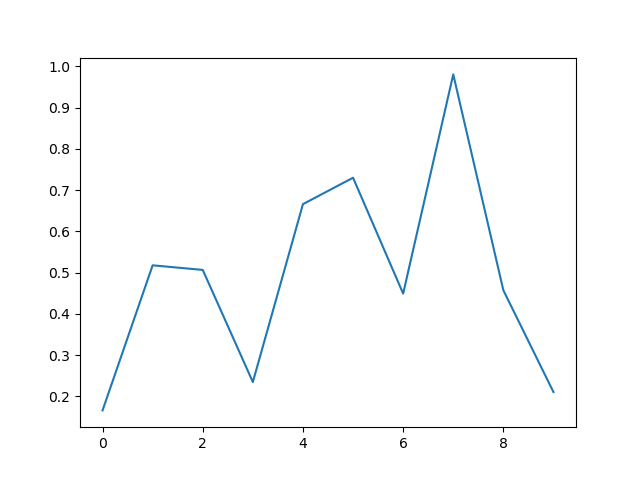

In [4]:
plt.figure()
lines = plt.plot(np.random.rand(10))

In [4]:
lines

In [5]:
lines[0].get_color()

'#1f77b4'

<IPython.core.display.Javascript object>


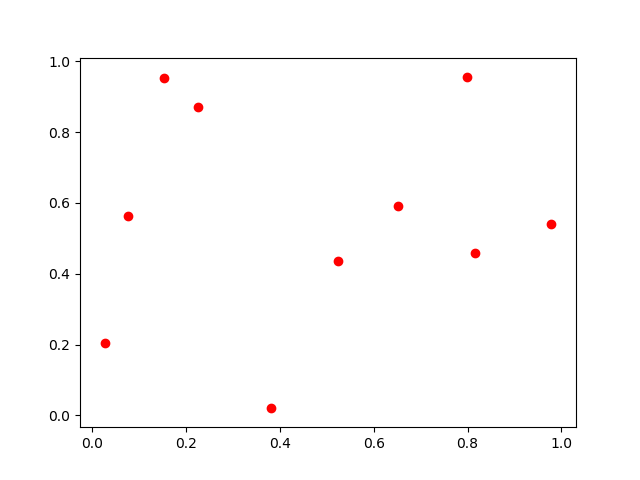

In [18]:
plt.figure()
sctr = plt.scatter(np.random.rand(10), np.random.rand(10))

In [19]:
sctr.set_color('r')

In [11]:
array = np.arange(10, 20)
ii = np.where(array == 12)
ii

(array([2]),)

In [12]:
ii[0]

array([2])

In [13]:
ii[0,0]

TypeError: tuple indices must be integers or slices, not tuple

> <ipython-input-13-2c4ec96c78f1>(1)<module>()
----> 1 ii[0,0]

ipdb> quit


In [14]:
ii[0][0]

2

In [16]:
def index(array, x):
    return np.where(np.array(array).flatten() == x)[0][0]

In [17]:
index((3, 4, 5), 4)

1

In [7]:
color = next(ax_te._get_lines.prop_cycler)['color']

In [8]:
color

'#ff7f0e'

In [13]:
import pandas as pd

probe_jsat = pd.read_excel("Isat_signals.xlsx", header=None)
probe_jsat = probe_jsat.to_numpy()

In [15]:
probe_jsat_channel = {}
for row in probe_jsat:
    probe_jsat_channel[row[0][-3:] + "-ch"] = row[2]
    probe_jsat_channel[row[0][-3:] + "-id"] = row[3] - 1

In [24]:
probe_jsat

array([['3ua1', 'Isng', 30, 1],
       ['3ua3', 'Isgn', 29, 3],
       ['3ua5', 'Isng', 30, 6],
       ['3ua7', 'Isgn', 30, 5],
       ['3um2', 'Isat', 27, 5],
       ['3um5', 'Isat', 28, 1],
       ['7oa1', 'Isat', 29, 1],
       ['7oa2', 'Isat', 28, 3],
       ['7oa3', 'Isat', 25, 5],
       ['7oa4', 'Isat', 27, 3],
       ['7oa5', 'Isat', 28, 1],
       ['7oi1', 'Isat', 30, 4],
       ['7oi3', 'Isat', 25, 1],
       ['7oi4', 'Isat', 25, 3],
       ['7oi5', 'Isgn', 31, 2],
       ['7oi7', 'Isat', 29, 5],
       ['8ua1', 'Isat', 21, 2],
       ['8ua2', 'Isat', 21, 3],
       ['8ua3', 'Isat', 21, 4],
       ['8ua4', 'Isat', 22, 2],
       ['8ua5', 'Isat', 22, 3],
       ['8ua6', 'Isat', 22, 5],
       ['8ua7', 'Isat', 23, 1],
       ['8ua8', 'Isat', 23, 3],
       ['8ua9', 'Isat', 23, 5],
       ['8uaA', 'Isat', 23, 6],
       ['8uaB', 'Isat', 24, 3],
       ['8uaC', 'Isat', 24, 6],
       ['8ui1', 'Isat', 25, 6],
       ['8ui2', 'Isat', 26, 1],
       ['8ui3', 'Isat', 26, 3],
       [

In [31]:
def get_jsat(shot, probe_name):
    
    gettem = getsig(shot, 'LSF', 'CH' + str(probe_jsat_channel[probe_name + '-ch']))
    gettem.data = gettem.data[probe_jsat_channel[probe_name + '-id']]
    
    return gettem

In [24]:
probe_channel["uic-id"]

1

In [17]:
proraw = getsig(shot, 'LSF', 'CH25')

In [21]:
proraw.__dict__

{'name': b'CH25',
 'header': <dd.signalGroupHeader at 0x2b3c3b68aa50>,
 'data': array([-0.00305206,  0.00305295, -0.00915706, ..., -0.00305206,
        -0.00305206,  0.00305295], dtype=float32),
 'time': array([5.0000000e-07, 3.5500001e-05, 7.0499998e-05, ..., 7.3832154e+00,
        7.3832507e+00, 7.3832855e+00], dtype=float32),
 'unit': b'AU',
 'area': None}

In [20]:
proraw.data = proraw.data[0]

In [4]:
get_jsat(38200, 'oa5').__dict__

PyddError: ('libddww error: Error by DDopen (8.1): shotfile does not exist !', {'experiment': b'AUGD', 'diagnostic': b'LSF', 'pulseNumber': 38205, 'edition': 0, 'function': 'shotfile.open', 'trace': ['_run_module_as_main', '_run_code', '<module>', 'launch_instance', 'IPKernelApp.start', 'AsyncIOMainLoop.start', '_UnixSelectorEventLoop.run_forever', '_UnixSelectorEventLoop._run_once', 'Handle._run', 'AsyncIOMainLoop.<lambda>', 'AsyncIOMainLoop._run_callback', 'Runner.inner', 'Runner.run', 'IPythonKernel.process_one', 'wrapper', 'IPythonKernel.dispatch_shell', 'wrapper', 'IPythonKernel.execute_request', 'wrapper', 'IPythonKernel.do_execute', 'ZMQInteractiveShell.run_cell', 'ZMQInteractiveShell.run_cell', 'ZMQInteractiveShell._run_cell', '_pseudo_sync_runner', 'ZMQInteractiveShell.run_cell_async', 'ZMQInteractiveShell.run_ast_nodes', 'ZMQInteractiveShell.run_code', '<module>', 'get_jsat', 'getsig', 'shotfile.__init__', 'shotfile.open']})

In [5]:
import dd

In [7]:
dd.PyddError

dd.PyddError

In [9]:
signal = getsig(shot, 'LSD', 'ne' + '-' + 'oa7')

In [12]:
signal.data

array([nan, nan, nan, ..., nan, nan, nan], dtype=float32)

In [13]:
import six

In [7]:
None.set_visible()

AttributeError: 'NoneType' object has no attribute 'set_visible'

> <ipython-input-7-661dfc7f5b1b>(1)<module>()
----> 1 None.set_visible()

ipdb> quit


In [8]:
x = True

In [13]:
x |= True

In [14]:
x

True